In [177]:
import pandas as pd
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

Or you can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
```

We need to take `bank/bank-full.csv` file from the downloaded zip-file.  
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not. 

In [2]:
data = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'

In [3]:
!wget $data

--2024-10-23 15:14:20--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [            <=>     ] 999.85K   201KB/s    in 5.1s    

2024-10-23 15:14:26 (194 KB/s) - ‘bank+marketing.zip’ saved [1023843]



In [4]:
zf = ZipFile('bank+marketing.zip', 'r')
zf.extractall('bank+marketing')
zf.close()

In [5]:
zf = ZipFile('bank+marketing/bank.zip', 'r')
zf.extractall('bank')
zf.close()

In [126]:
import pandas as pd
import numpy as np

In [147]:
df = pd.read_csv("bank/bank-full.csv", sep = ";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [148]:
features = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign',
            'pdays','previous','poutcome','y']
df_new = df[features].copy()

In [149]:
df_new.y = (df_new.y=='yes').astype(int)

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
df_full_train, df_test = train_test_split(df_new, test_size=0.2, random_state=1)

In [152]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [153]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [154]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [155]:
del df_train['y']
del df_val['y']
del df_test['y']

In [156]:
df_full_train.reset_index(drop=True, inplace=True)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [157]:
from sklearn.metrics import roc_auc_score

In [158]:
numerical_var = ['balance', 'day', 'duration', 'previous']

auc_scores = {}
for feature in numerical_var:
    y_pred = df_train[feature].values

    score = roc_auc_score(y_true = y_train, y_score=y_pred)

    if(score<0.5):
        score = roc_auc_score(y_true = y_train, y_score=-y_pred)
    auc_scores[feature]= score

for item in auc_scores:
    print(item, ":", auc_scores[item])

balance : 0.5888313805382317
day : 0.525957882383908
duration : 0.8147002759670778
previous : 0.5985653242764153


In [159]:
print(f"duration has the highest AUC of {auc_scores['duration']}")

duration has the highest AUC of 0.8147002759670778


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [160]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [165]:
categorical = list(df_new.dtypes[df_new.dtypes=='object'].index)
numerical = list(set(features)-set(categorical))
numerical.remove('y')

In [166]:
categorical, numerical

(['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'],
 ['campaign', 'previous', 'day', 'balance', 'pdays', 'duration', 'age'])

In [167]:
def train(df, y):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [168]:
dv, model = train(df_train, y_train)

In [169]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [170]:
y_pred = predict(df_val, dv, model)

In [171]:
round(roc_auc_score(y_val, y_pred),3)

0.9

The closest option to my answer is 0.89

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865


In [197]:
def precision_recall_dataframe(y_val, y_pred):
    scores =[]
    thresholds = np.arange(0.0,1.0,0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred>=t)
        predict_negative = (y_pred<t)

        true_pos = (predict_positive & actual_positive).sum()
        true_neg = (predict_negative & actual_negative).sum()

        false_pos = (predict_positive & actual_negative).sum()
        false_neg = (predict_negative & actual_positive).sum()

        scores.append((t,true_pos,false_pos,false_neg,true_neg))
        
    columns = ['threshold', 'tp', 'fp', 'fn','tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['precision'] = round(df_scores.tp/ (df_scores.tp+df_scores.fp),3)
    df_scores['recall'] = round(df_scores.tp / (df_scores.tp+df_scores.fn),3)

    return df_scores

In [198]:
df_scores = precision_recall_dataframe(y_val, y_pred)

In [199]:
df_scores[::11]

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121,1.000
11,0.11,890,1362,208,6582,0.395,0.811
22,0.22,691,620,407,7324,0.527,0.629
33,0.33,533,365,565,7579,0.594,0.485
44,0.44,422,238,676,7706,0.639,0.384
55,0.55,332,163,766,7781,0.671,0.302
66,0.66,250,112,848,7832,0.691,0.228
77,0.77,177,76,921,7868,0.700,0.161
88,0.88,89,36,1009,7908,0.712,0.081
99,0.99,10,6,1088,7938,0.625,0.009


In [219]:
from shapely.geometry import LineString

In [229]:
first_line = LineString(np.column_stack((df_scores.threshold, df_scores.precision)))
second_line = LineString(np.column_stack((df_scores.threshold, df_scores.recall)))
intersection = first_line.intersection(second_line)
intesection_threshold, precision_recall = intersection.xy

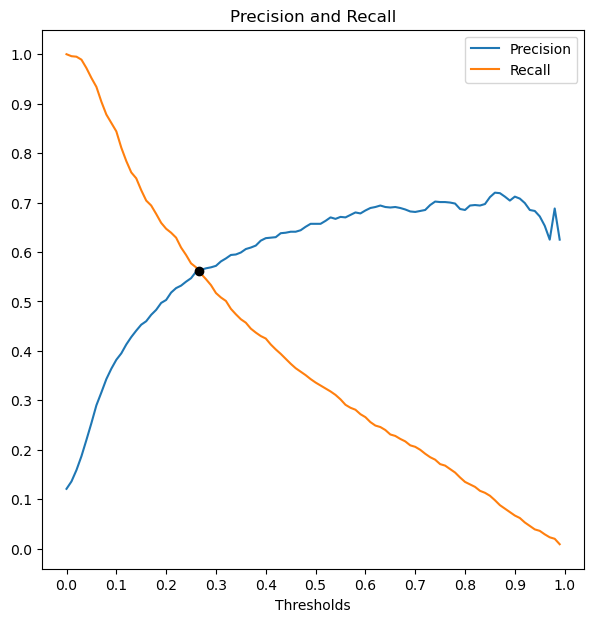

In [236]:
plt.figure(figsize=(7,7))
plt.plot(df_scores.threshold, df_scores['precision'], label = 'Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label = 'Recall')
plt.plot(*intersection.xy,'o', color='black')
plt.legend()

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Thresholds')
plt.title('Precision and Recall')

plt.show()

In [238]:
print(f"The threshold precision and recall curves intersect at {intesection_threshold[0]:0.3f}")

The threshold precision and recall curves intersect at 0.265


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


In [239]:
df_scores['F1_score'] = 2* (df_scores.precision * df_scores.recall) /(df_scores.precision + df_scores.recall)

In [240]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall,F1_score
0,0.00,1098,7944,0,0,0.121,1.000,0.215879
1,0.01,1094,6958,4,986,0.136,0.996,0.239322
2,0.02,1093,5764,5,2180,0.159,0.995,0.274185
3,0.03,1086,4733,12,3211,0.187,0.989,0.314529
4,0.04,1067,3776,31,4168,0.220,0.972,0.358792
...,...,...,...,...,...,...,...,...
95,0.95,39,19,1059,7925,0.672,0.036,0.068339
96,0.96,32,17,1066,7927,0.653,0.029,0.055534
97,0.97,25,15,1073,7929,0.625,0.023,0.044367
98,0.98,22,10,1076,7934,0.688,0.020,0.038870


In [244]:
max_row_idx = df_scores['F1_score'].idxmax()
df_scores.iloc[max_row_idx]

threshold       0.2200
tp            691.0000
fp            620.0000
fn            407.0000
tn           7324.0000
precision       0.5270
recall          0.6290
F1_score        0.5735
Name: 22, dtype: float64

In [245]:
print(f"F1 is maximal at threshold {df_scores.iloc[max_row_idx].threshold}")

F1 is maximal at threshold 0.22


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [247]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [250]:
scores = []
Kfold = KFold(n_splits=5, shuffle=True, random_state = 1)
for train_idx, val_idx in tqdm(Kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    scores.append(roc_auc_score(y_val, y_pred))

0it [00:00, ?it/s]

In [251]:
print("%.3f +- %.3f"% (np.mean(scores), np.std(scores)))

0.906 +- 0.006


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [252]:
def train(df, y_train, c=1.0):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(max_iter=100000,C=c)
    model.fit(X_train, y_train)

    return dv, model

In [255]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, c=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.824 +- 0.009
C=0.001 0.886 +- 0.005
C=1 0.906 +- 0.006


The best mean score is 0.906 for c=1.